# Cost Analysis

This notebook describes the process in determining the most significant factors for the total installed cost for the solar PV projects. 

## Relevant Packages

The following packages were imported:

In [57]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
# Note - you will need version 0.24.1 of scikit-learn to load this library (SequentialFeatureSelector)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


## Dataset

The datasets from Berkeley Lab's *Tracking the Sun* report were used for the analysis.  

In [33]:
# Main dataset
data = pd.read_csv('datasets/TTS_data.csv')

/home/tessmachado/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,3,13,28,29,30,31,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
data = data.where(data['totalInstalledCost___'] != -1).dropna()
data.head()

,Unnamed: 0,dataProvider1,dataProvider2,program1ProjectID,PTODate_orProxy_,systemSizeInDCSTC_KW_,totalInstalledCost___,Up_FrontCashIncentive___,customerSegment,is_expansion,...,inv_model1_clean,inverterQuantity_1,additionalInverterModels_Y_N_,inv_microinv1,inv_battery_hybrid1,inv_builtin_meter1,inv_outputcapacity1,dc_optimizer,ILR,TotalModuleQty
107186,107186.0,Arizona Public Service,-1,107903,17-Jun-20,5.760,17488.26,-1.0,RES,0.0,...,SE6000H-US [240V],-1.0,-1.0,0.0,0.0,1.0,6.046,1.0,-1.0,-1.0
107187,107187.0,Arizona Public Service,-1,107904,17-Jun-20,8.750,22631.00,-1.0,RES,0.0,...,IQ6PLUS-72-x-US [240V],-1.0,-1.0,1.0,0.0,0.0,0.280,0.0,-1.0,-1.0
107301,107301.0,Arizona Public Service,-1,108026,19-Jun-20,4.725,18972.00,-1.0,RES,0.0,...,SB5000US (240V),-1.0,-1.0,0.0,0.0,1.0,5.000,0.0,-1.0,-1.0
107332,107332.0,Arizona Public Service,-1,108059,22-Jun-20,3.550,9900.00,-1.0,RES,0.0,...,Solaria PowerXT-355R-AC [240V],-1.0,-1.0,1.0,0.0,0.0,0.290,0.0,-1.0,-1.0
107386,107386.0,Arizona Public Service,-1,108117,23-Jun-20,5.850,20475.00,-1.0,RES,0.0,...,SE6000H-US [240V],-1.0,-1.0,0.0,0.0,1.0,6.046,1.0,-1.0,-1.0


## Heatmaps

Heatmaps were generated of the main dataset to observe any correlation between the total installed cost (totalInstalledCost__) and the remaining features.

<AxesSubplot:>

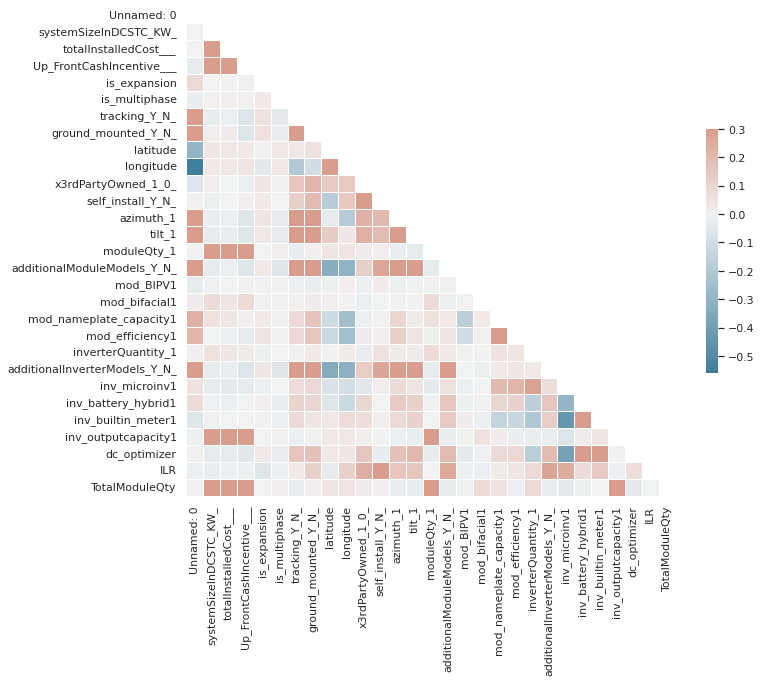

In [35]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


The following heatmap only shows columns in the dataset with int or float values.

<AxesSubplot:>

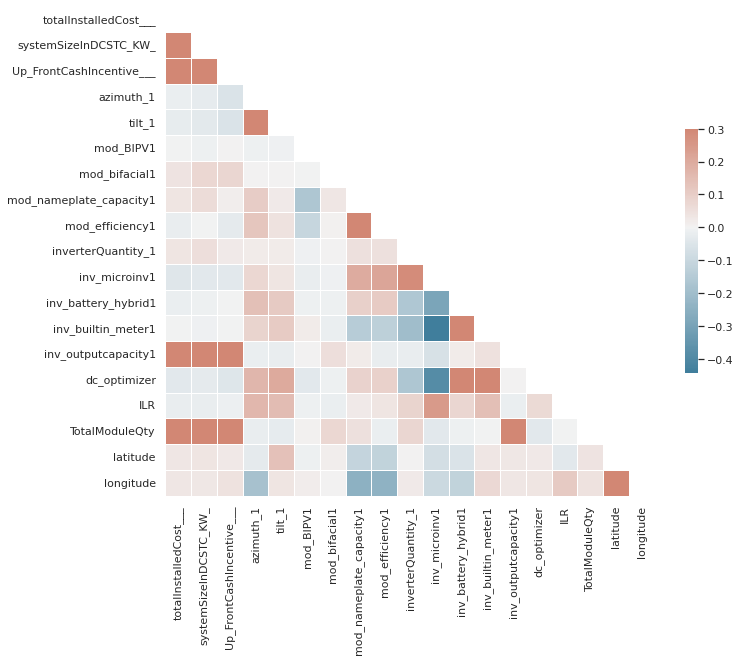

In [52]:
from string import ascii_letters

df = data[['totalInstalledCost___', 'systemSizeInDCSTC_KW_', 'Up_FrontCashIncentive___', 'azimuth_1', 'tilt_1', 'mod_BIPV1', 
        'mod_bifacial1', 'mod_nameplate_capacity1', 'mod_efficiency1', 'inverterQuantity_1', 
        'inv_microinv1', 'inv_battery_hybrid1', 'inv_builtin_meter1', 'inv_outputcapacity1', 
        'dc_optimizer', 'ILR', 'TotalModuleQty', 'latitude', 'longitude']]
df = df.dropna(subset=['latitude', 'longitude'])

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Stepwise Selection

The results from forward and backward stepwise selection were used to determine the most significant contributors to the total installed cost.

First, the data was split into a training and test set. The following columns were chosen since they contain int/float values. To change the tested features, both X and names (variables) should be changed. 

In [36]:
X = data[['systemSizeInDCSTC_KW_', 'Up_FrontCashIncentive___', 'azimuth_1', 'tilt_1', 
        'mod_nameplate_capacity1', 'inverterQuantity_1', 'inv_outputcapacity1', 
        'ILR', 'TotalModuleQty', 'latitude', 'longitude','mod_efficiency1']]

y = data['totalInstalledCost___']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=9, shuffle = True)

In [37]:
names = 'systemSizeInDCSTC_KW_', 'Up_FrontCashIncentive___', 'azimuth_1', 'tilt_1', 'mod_nameplate_capacity1', 'inverterQuantity_1', 'inv_outputcapacity1', 'ILR', 'TotalModuleQty', 'latitude', 'longitude','mod_efficiency1'
f_names = np.array(names)

Foward stepwise selection was done on the features previously defined. The number of features selected (n_features_to_select) can be changed when defining SequentialFeatureSelector().

In [38]:
# Forward stepwise selection
def forward_stepwise_selection(X, y, f_names):
    sfs_forward = SequentialFeatureSelector(linear_model.LinearRegression(), 
                                        n_features_to_select=5, 
                                        direction = 'forward').fit(X,y)
    print('support: ', sfs_forward.get_support(), "\n")
    selected = sfs_forward.get_support(indices = True)
    print(selected)
    print('Selected input features using Forward Stepwise Selection: \n', f_names[selected])
    
    return f_names[selected]

fsc = forward_stepwise_selection(X, y, f_names)

support:  [ True False False False  True False False False  True  True False  True] 

[ 0  4  8  9 11]
Selected input features using Forward Stepwise Selection: 
 ['systemSizeInDCSTC_KW_' 'mod_nameplate_capacity1' 'TotalModuleQty'
 'latitude' 'mod_efficiency1']


Backward stepwise selection was also done on the features to compare to the results from the forward stepwise selection. Again, the number of selected features can be changed, but for comparison with forward selection, this is set equal. 

In [39]:
# Backward stepwise selection
def backward_stepwise_selection(X, y, f_names):
    sfs_backward = SequentialFeatureSelector(linear_model.LinearRegression(), 
                                        n_features_to_select=5, 
                                        direction = 'backward').fit(X,y)
    print('support: ', sfs_backward.get_support(), "\n")
    selected = sfs_backward.get_support(indices = True)
    print(selected)
    print('Selected input features using Forward Stepwise Selection: \n', f_names[selected])
    
    return f_names[selected]

bsc = backward_stepwise_selection(X, y, f_names)

support:  [ True False False False  True False False  True  True False False  True] 

[ 0  4  7  8 11]
Selected input features using Forward Stepwise Selection: 
 ['systemSizeInDCSTC_KW_' 'mod_nameplate_capacity1' 'ILR' 'TotalModuleQty'
 'mod_efficiency1']


The selected features from the forward and backward stepwise selection were compared to determine the features that were not shared between the two methods. 

In [40]:
def different_values(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))

print(difference(fsc, bsc))

['ILR', 'latitude']


The following function is used to determine all unique selected features.

In [50]:
def unique_values(list1, list2):
    return list(set(list1) | (set(list2)))

print(unique(fsc, bsc))

['TotalModuleQty', 'latitude', 'mod_efficiency1', 'ILR', 'mod_nameplate_capacity1', 'systemSizeInDCSTC_KW_']


## Random Forest Regression

A sub-dataset was created using the unique selected features and strong correlations seen on the heatmap. The subset contains the following data: 'systemSizeInDCSTC_KW_', 'Up_FrontCashIncentive___' , 'mod_nameplate_capacity1',  'ILR', 'TotalModuleQty', 'latitude', 'totalInstalledCost___', 'mod_efficiency1'. The subset was then parsed down further by excluding rows that contained any -1 values.

In [51]:
df_reg = data[['systemSizeInDCSTC_KW_', 'Up_FrontCashIncentive___' , 'mod_nameplate_capacity1',  'ILR', 
        'TotalModuleQty', 'latitude', 'totalInstalledCost___', 'mod_efficiency1']]
df_reg = df_reg.where(data['systemSizeInDCSTC_KW_'] != -1).dropna()
df_reg = df_reg.where(data['mod_nameplate_capacity1'] != -1).dropna()
df_reg = df_reg.where(data['ILR'] != -1).dropna()
df_reg = df_reg.where(data['TotalModuleQty'] != -1).dropna()
df_reg = df_reg.where(data['latitude'] != -1).dropna()
df_reg = df_reg.where(data['mod_efficiency1'] != -1).dropna()
df_reg = df_reg.where(data['Up_FrontCashIncentive___'] != -1).dropna()

The heatmap below shows the correlation between features in df_reg.

<AxesSubplot:>

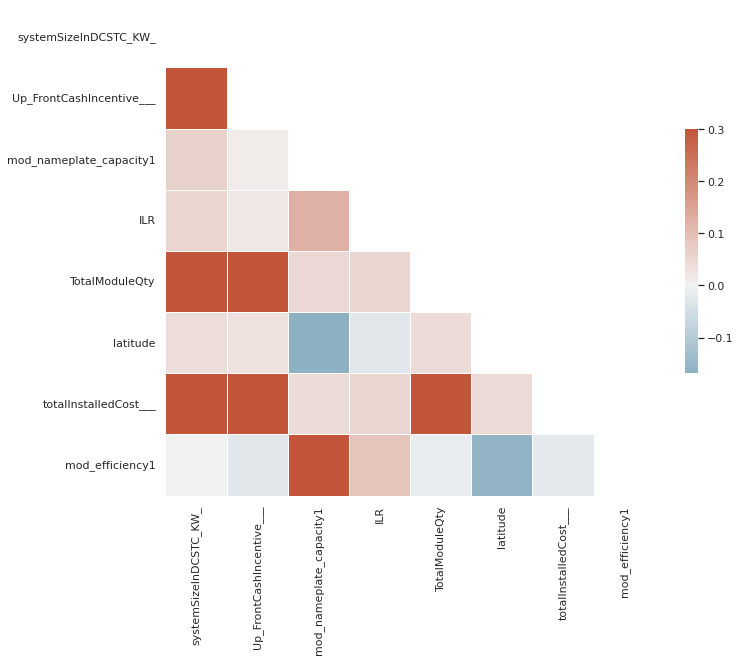

In [53]:
from string import ascii_letters

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df_reg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Because the goal of the model is predicted the total installation cost, X and y were defined as follows. The data was then randomly split into test and training data. 

In [54]:
X = df_reg[['systemSizeInDCSTC_KW_',  'mod_nameplate_capacity1',  'ILR', 'TotalModuleQty', 'latitude', 'mod_efficiency1']]
y = df_reg['totalInstalledCost___']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=9, shuffle = True)

A random forest regressor function was defined. From this, the $R^{2}$ value and the y prediction can be determined. 

In [55]:
# Random Forest Regressor
def random_forest_reg(X_train, y_train, X_test, y_test):
    clf_RF = RandomForestRegressor(n_estimators = 100, max_depth = 4, max_features = 2, random_state = 7)
    clf_RF = clf_RF.fit(X_train, y_train)
    y_predict = clf_RF.predict(X_test)
    mse_RF = mean_squared_error(y_test, y_predict)
    r2_RF = r2_score(y_test, y_predict)
    print('MSE: ', mse_RF)
    print('R2: ', r2_RF)
    return r2_RF, y_predict

r2_RF, y_predict_RF = random_forest_reg(X_train, y_train, X_test, y_test)

MSE:  13605078698.109854
R2:  0.8658832508130803


A plot is created to see the distribution between the predicted and actual total installation costs. The ideal total installation cost line was overlayed onto the plot.

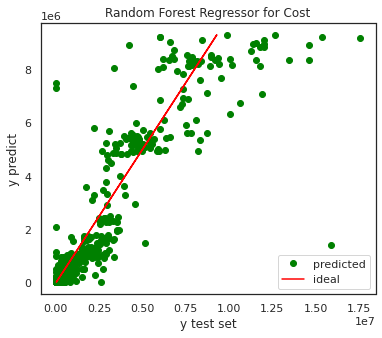

R2:  0.8658832508130803


In [56]:
plt.figure(figsize = (6,5))
plt.plot(y_test, y_predict_RF, 'o', color = 'green', label = 'predicted')
plt.plot(y_predict_RF, y_predict_RF, '-', color = 'red', label = 'ideal')

plt.title('Random Forest Regressor for Cost')
plt.xlabel('y test set')
plt.ylabel('y predict')
plt.legend()

plt.show()

print('R2: ', r2_RF)